This notebook includes an analysis of the network of institutions who have participated in Horizon2020 programme projects that have started in 2015 or 2016. Projects that fall into the Call categories H2020-ICT-2014-2, H2020-ICT-2014-1, H2020-ICT-2015 are included in the analysis. 

First, import the necessary libraries.

In [64]:
#%matplotlib inline
%matplotlib inline
#make integer division give a floating point number
from __future__ import division
#Set working directory
import os as osvariable
osvariable.chdir("C:/Users/Mustafa/Desktop/datamining/Horizon2020")
import numpy as np
import pandas as pd
from pandas import read_csv
#Import plotting library
import matplotlib.pyplot as plt
from sklearn import linear_model
from collections import defaultdict
from scipy.stats import t

Read the data file. 

In [13]:
#Read the raw data file
projects_institutions = read_csv('projects-institutions.csv')

#Take a look at the first 5 observations
print(projects_institutions.head())

   reference                                        coordinator  \
0     645149                                     SafeTRANS e.V.   
1     644090  COMMISSARIAT A L ENERGIE ATOMIQUE ET AUX ENERG...   
2     688127  THE PROVOST, FELLOWS, FOUNDATION SCHOLARS & TH...   
3     687772                                      ATOS SPAIN SA   
4     687780                                   INMARK EUROPA SA   

                                        participants  
0  AIT Austrian Institute of Technology GmbH;KUNG...  
1  THE CONNECTED DIGITAL ECONOMY CATAPULT LIMITED...  
2  TRACOIN QUALITY BV;TRILATERAL RESEARCH & CONSU...  
3  ETHNIKO KENTRO EREVNAS KAI TECHNOLOGIKIS ANAPT...  
4  WATERFORD INSTITUTE OF TECHNOLOGY;HEWLETT PACK...  


Participants are all in one field, separated by semicolon. 
We will create a dictionary with the coordinator as the key 
and the participants as the dictionary values.

In [14]:
coordinators_participants = defaultdict(list)
#Create the set of institutions. The set keeps only one
#instance of each project
institutions = set()
for i in xrange(len(projects_institutions)):
    #Get the participants of project i. The institution names are 
    #separated by semi-columns
    current_participant_list = projects_institutions.loc[i]['participants'].split(';')
    #In the dictionary, create a key using the reference number of the project 
    #and append the project coordinator as the first value 
    coordinators_participants[projects_institutions.loc[i]['reference']].append(projects_institutions.loc[i]['coordinator'])
    #Add all participants (not the coordinator) to the dictionary    
    for j in xrange(len(current_participant_list)):
        coordinators_participants[projects_institutions.loc[i]['reference']].append(current_participant_list[j])
    #Add the coordinator and the participants to the set of projects 
    institutions.add(projects_institutions.loc[i]['coordinator'])
    institutions.update(current_participant_list)

Get the list of institutions.

In [15]:
#Convert the project set to a list
institutions = list(institutions)
#Get the number of institutions
number_of_institutions = len(institutions)
print('Number of institutions: %i' % number_of_institutions)
#Output the list of institutions
pd.DataFrame(institutions).to_csv('institutions.csv',index = False)
#Get the number of projects
number_of_projects = len(coordinators_participants)
print('Number of projects: %i' % len(coordinators_participants))

Number of institutions: 1908
Number of projects: 384


There are 1908 institutions and 384 projects. We now create the 1908 by 1908 undirected institution matrix. In the undirected institution matrix, the role of the institution (coordinator or partners) does not matter. We are only interested in seeing if the institution are in a project together. The entries of this matrix will be the number of projects the two institutions are in together.

In [16]:
institution_matrix_undirected = np.zeros(shape=(number_of_institutions,number_of_institutions))

Create the directed institution matrix. In the directed institution matrix, if an institution is a institution in a project coordinated by another 
institution, the matrix entry with the institution's row and coordinator's column is increased by one.

In [17]:
institution_matrix_directed = np.zeros(shape=(number_of_institutions,number_of_institutions))

Populate the matrices. 

In [18]:
for reference, participants in coordinators_participants.iteritems():
    #The first institution in the list is the coordinator.
    #In the column of the coordinator, increase the value of the directed 
    #graph matrix by one at the row of each participant
    for j in range(1,len(participants)):
        institution_matrix_directed[institutions.index(participants[0])][institutions.index(participants[j])] = institution_matrix_directed[institutions.index(participants[0])][institutions.index(participants[j])] + 1
    #For every participant in this project
    for i in xrange(len(participants)):
        #For every other participant
        for j in xrange(i):
            #Increase the intersecting row and column of the undirected matrix by 1
            institution_matrix_undirected[institutions.index(participants[i])][institutions.index(participants[j])] = institution_matrix_undirected[institutions.index(participants[i])][institutions.index(participants[j])] + 1
            institution_matrix_undirected[institutions.index(participants[j])][institutions.index(participants[i])] = institution_matrix_undirected[institutions.index(participants[j])][institutions.index(participants[i])] + 1

#Output the directed and undirected matrix
pd.DataFrame(institution_matrix_directed).to_csv('institution_matrix_directed.csv',index = False)
pd.DataFrame(institution_matrix_undirected).to_csv('institution_matrix_undirected.csv',index = False)           

Start calculating the degree values of participants. The degree of a participant is the number of connections it has with other participants.

In [19]:
degree = []
for i in xrange(number_of_institutions):
    degree.append(int(sum(institution_matrix_undirected[i])))

Calculate the average degree value of the graph 

In [20]:
total_connections = sum(degree)
average_connections = total_connections/number_of_institutions
print('Average connections %.3f: ' % average_connections)

Average connections 16.398: 


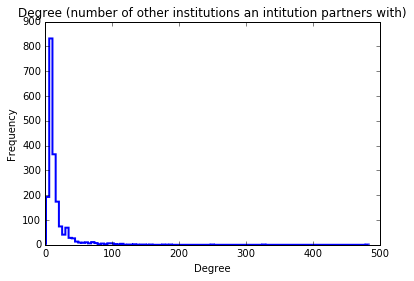

In [48]:
#Plot the histogram of degree
plt.figure(1)
plt.hist(degree,bins= 100, label = "Degree",histtype = "step", lw = 2)
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Degree (number of other institutions an intitution partners with)')
plt.savefig('Degree histogram')

Start calculating the clustering coefficient. Clustering coefficient measures how cliquish the institution is. It is a measure of the density of edges in the neighborhood of the institution (Zaki and Maira).

In [21]:
clustering_coefficient = []

#For each participant
for i in xrange(number_of_institutions):
    neighbor_index = []    
    number_of_neighbors = []
    #For this participant, get the indices of its partners
    for j in xrange(number_of_institutions):
        if institution_matrix_undirected[i][j] > 0:
            neighbor_index.append(j)
    #For partner g of participant i, calculate the 
    #number of connections partner g has with the rest 
    #of the partners of participant i
    for g in neighbor_index:
        number_of_neighbors.append(sum(institution_matrix_undirected[g][neighbor_index] > 0))
        #print(sum(institution_matrix_undirected[g][neighbor_index] > 0),sum(number_of_neighbors))
    #Clustering coefficient equals the proportion of the connections among 
    #the partners of participant i to the total number of possible connections
    #among the partners of participant i
    if len(neighbor_index) < 3:
        clustering_coefficient.append(0)
    else:
        clustering_coefficient.append(sum(number_of_neighbors)/(len(neighbor_index) * (len(neighbor_index) - 1)))    

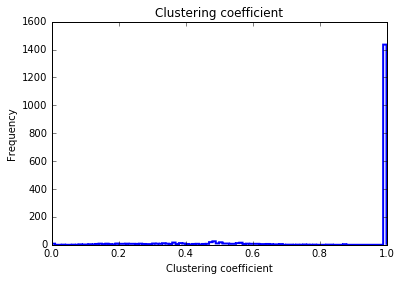

In [50]:
#Plot the histogram of clustering_coefficient
plt.figure(2)
plt.hist(clustering_coefficient,bins= 100, label = "Clustering coefficient",histtype = "step", lw = 2)
plt.xlabel('Clustering coefficient')
plt.ylabel('Frequency')
plt.title('Clustering coefficient')
plt.savefig('Clustering coefficient histogram')

In [22]:
#Calculate the average clustering coefficient.
print('Average clustering coefficient: %.3f' % np.average(clustering_coefficient))

Average clustering coefficient: 0.853


Get the adjacency matrix adjacency matrix has a value of 1 if two participants have a connection and 0 otherwise.

In [23]:
adjacence_matrix = np.zeros(shape=(number_of_institutions,number_of_institutions))

#For each institution, set the value of the 
#entry to 1 if it is in the same project as
#the other instituion
for k in xrange(number_of_institutions):
    for i in xrange(number_of_institutions):
        if institution_matrix_undirected[k][i] > 0:
            adjacence_matrix[k][i] = 1

Start creating the distance matrix. The distance between the two institutions is the smallest number of institutions needed to be visited to get from the one to another in the network. The Floyd-Warshall algorithm iterates through the pairs of nodes (institutions) in the network to calculate the shortest path. The distance between the two institions is infinity if they are not in any projects together. An institution's distance between itself is zero. The Floyd-Warshall algorithm implementation here is from Wikipedia entry: https://en.wikipedia.org/wiki/Floyd%E2%80%93Warshall_algorithm

In [24]:
distance_matrix = np.ones(shape=(number_of_institutions,number_of_institutions))
#Set all distance values to infinity.  
for i in xrange(number_of_institutions):
    for j in xrange(number_of_institutions):
        distance_matrix[i][j] = np.inf

next_matrix = np.ones(shape=(number_of_institutions,number_of_institutions))
#Set all distance values to null.  
for i in xrange(number_of_institutions):
    for j in xrange(number_of_institutions):
        next_matrix[i][j] = np.nan

#Set all distances to self to 0
for i in xrange(number_of_institutions):
    distance_matrix[i][i] = 0    

#If two institutions are in the same project, their distance is one    
for i in xrange(number_of_institutions):
    for j in xrange(number_of_institutions):
        if adjacence_matrix[i][j] > 0:
            distance_matrix[i][j] = adjacence_matrix[i][j]
            next_matrix[i][j] = j

Run the Floyd-Warshall algorithm. This takes about 2.50 hours. 

In [ ]:
for k in xrange(number_of_institutions):
    for i in xrange(number_of_institutions):
        for j in xrange(number_of_institutions):
            if distance_matrix[i][j] > distance_matrix[i][k] + distance_matrix[k][j]:
                distance_matrix[i][j] = distance_matrix[i][k] + distance_matrix[k][j]

Check to see if there are any infinate distances.

In [43]:
print('Number of infinite distances: %.0f' % (len(np.ravel(distance_matrix)[(np.ravel(distance_matrix) == np.inf)])/2))

Number of infinite distances: 47283


The largest distance between any two nodes in the network is the diameter of the network. The diameter of the network is infinate.

In [42]:
#Print the maximum distance (excluding infinite distances)
print('Maximum distance between any two nodes in the graph: %.0f' % (max(np.ravel(distance_matrix)[(np.ravel(distance_matrix) != np.inf)])))

Maximum distance between any two nodes in the graph: 7


Plot the histogram of the distances, ignore 0 and infinite distances

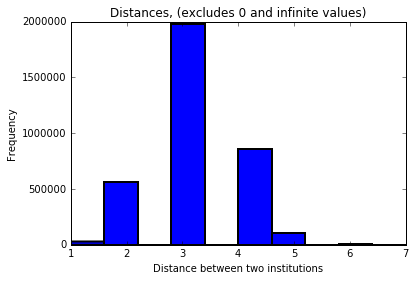

In [56]:
plt.figure(3)
plt.hist(np.ravel(distance_matrix)[((np.ravel(distance_matrix) != np.inf) & (np.ravel(distance_matrix) != 0))], label = "Distances (0 and infinite distances not included)", lw = 2)
plt.xlabel("Distance between two institutions")
plt.ylabel("Frequency")
plt.title('Distances, (excludes 0 and infinite values)')
plt.savefig('Distance histogram')

Start calculating the average path length of the graph. Infinite distances (distances between two participants who do not collaborate in any project) are excluded from the calculation.

In [57]:
total_distance = 0
counter = 0
for i in xrange(number_of_institutions):
    for j in xrange(i):
        if distance_matrix[i][j] != np.inf:
            total_distance = total_distance + distance_matrix[i][j]
            counter = counter + 1    
average_distance = total_distance/counter

#Average distance
print('Average distance between any two nodes, excluding infinite distances: %.3f' % average_distance)
#Number of institutions
print('Log of number of institutions: %.3f ' % np.log(number_of_institutions))

Average distance between any two nodes, excluding infinite distances: 3.135
Log of number of institutions: 7.554 


Start calculating the eccentricity of participants. The eccentricity of a participant is the maximum distance it has with any other participant. We ignore the infinite distances when calculating eccentricity.

In [58]:
eccentricity = []
for k in xrange(number_of_institutions):
    eccentricity.append(max(distance_matrix[k][(distance_matrix[k] != np.inf)]))

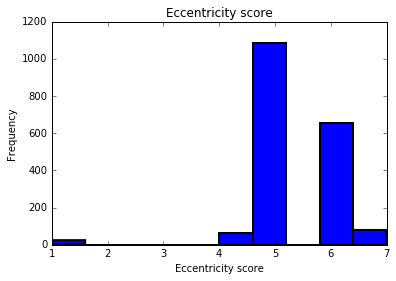

In [59]:
#Plot the histogram of eccentricities
plt.figure(4)
plt.hist(eccentricity, lw = 2)
plt.xlabel("Eccentricity score")
plt.ylabel("Frequency")
plt.title("Eccentricity score")
plt.savefig('Eccentricity histogram')

Calculate the diameter of the graph. The diameter is the maximum eccentricity among the participants.

In [60]:
diameter = max(eccentricity)
print('Diameter of the graph: %.3f' % diameter)

Diameter of the graph: 7.000


Calculate the efficiency of the graph. The efficiency of the graph is found by the average efficiency of all pairs of nodes. The efficiency of a pair of nodes is the inverse of the distance between them. The smaller the distance, the more 'efficient' the communication between them. If there is no connectio between two nodes, the efficiency between them is 0, as the distance between them is infinite.

In [46]:
efficiency = 0
for i in xrange(number_of_institutions):
    for j in xrange(i):
        efficiency = efficiency + 1/distance_matrix[i][j]
efficiency = 2 * efficiency / (number_of_institutions * (number_of_institutions - 1))

print('Efficiency: %.3f' % efficiency)

Efficiency: 0.332


We will calculate the authority and hub score of participants. Authorithy is a measure of how many good institutions it coordinates. A coordinator with a high authority coordinates many hub participants. In the directed adjacency matrix. Hub score is a measure of how many good participants it is coordinated by. A participant with a high hub score is coordinated by participants with high authority. We use the directed adjacency matrix to calculate the authority and hub scores. 

In [47]:
adjacency_matrix_directed = np.zeros(shape=(number_of_institutions,number_of_institutions))

for i in xrange(number_of_institutions):
    for j in xrange(number_of_institutions):
        if institution_matrix_directed[i][j] >= 1:
            adjacency_matrix_directed[i][j] = 1 

Calculate the indegree of institutions. The indegree is the number of participant an institution coordinates.

In [48]:
indegree = []
for i in xrange(number_of_institutions):
    indegree.append(sum(np.transpose(institution_matrix_directed)[i]))

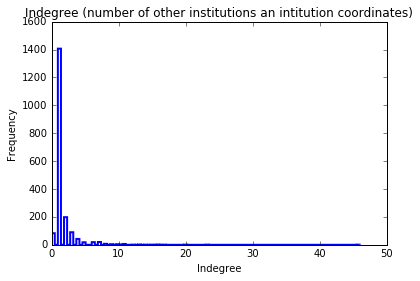

In [49]:
#Plot the histogram of indegree
plt.figure(5)
plt.hist(indegree,bins= 100, label = "Indegree",histtype = "step", lw = 2)
plt.xlabel('Indegree')
plt.ylabel('Frequency')
plt.title('Indegree (number of other institutions an intitution coordinates)')
plt.savefig('Indegree histogram')

In [50]:
#Set a threshold for convergence
threshold = 0.001
#Create the hub score list
h_convergence_list = []
#Create the authority score list
a_convergence_list = []
#Set converged to False
converged = False
#Set the initial authority scores to one.
a_new = np.ones(number_of_institutions)
#Set the initial hub scores to one.
h_new = np.ones(number_of_institutions)
while not converged:
    h_old = h_new    
    a_old = a_new
    h_max_old = np.max(h_old)
    a_max_old = np.max(a_old)
    h_new = np.dot(adjacency_matrix_directed, a_old)
    h_new = h_new/max(h_new)
    a_new = np.dot(np.transpose(adjacency_matrix_directed), h_new)
    a_new = a_new/max(a_new)
    a_convergence = np.sqrt(sum(np.power((a_new - a_old),2)))
    h_convergence = np.sqrt(sum(np.power((h_new - h_old),2)))
    if a_convergence < threshold and h_convergence < threshold:
        converged = True
    h_convergence_list.append(h_convergence)
    a_convergence_list.append(a_convergence)  

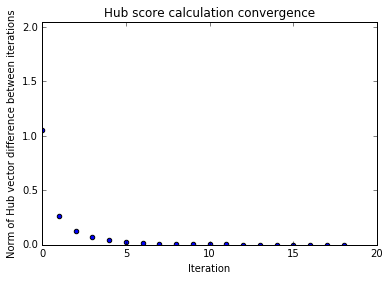

In [51]:
plt.figure(6)
plt.scatter(range(0,len(h_convergence_list[1:])),h_convergence_list[1:])    
plt.xlim([0,(len(h_convergence_list[1:]) + 1)])
plt.ylim([0,(max(h_convergence_list[1:]) + 1)])
plt.xlabel("Iteration")
plt.ylabel("Norm of Hub vector difference between iterations")
plt.title("Hub score calculation convergence")
plt.savefig('Hub scores')

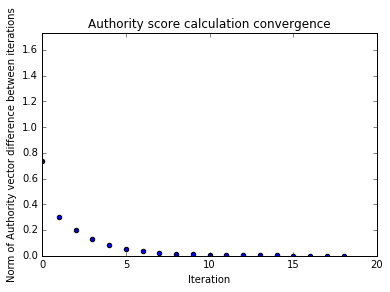

In [52]:
plt.figure(7)
plt.scatter(range(0,len(a_convergence_list[1:])),a_convergence_list[1:])
plt.xlim([0,(len(a_convergence_list[1:]) + 1)])
plt.ylim([0,(max(a_convergence_list[1:]) + 1)])
plt.xlabel("Iteration")
plt.ylabel("Norm of Authority vector difference between iterations")
plt.title("Authority score calculation convergence")
plt.savefig('Authority scores')


Start calculating the prestige score. From Zaki and Meira: "As a centrality, prestige is supposed to be a measure of the importance or rank of a node. Intuitively the more the links that point to a given node, the higher its prestige. However, prestige does not depend simply on the indegree; it also (recursively) depends on the prestige of the nodes that point to it."

In [53]:
prestige_old = np.ones(number_of_institutions)
#Create the eigenvalue list
eigenvalue_list = []
converged = False
while not converged:
    #Get the maximum of the prestige vector
    max_old = max(prestige_old)  
    #Update the prestige estimates
    prestige_new = np.dot(np.transpose(adjacency_matrix_directed),prestige_old)    
    #Get the new maximum of the prestige vector    
    max_new = max(prestige_new)
    #Get an estimate of the eigenvalue
    eigenvalue = max_new / max_old
    #Add the eigenvalue estimate to the list
    eigenvalue_list.append(eigenvalue)
    #Scale the prestige vector to prevent overflow
    prestige_new = prestige_new / max(prestige_new)
    #If the norm of the difference between the new and the old 
    #prestige vector is smaller than the threshold, stop the iterations
    if np.sqrt(sum(np.power((prestige_new - prestige_old),2))) < threshold:
        converged = True
    #Update the old prestige vector    
    prestige_old = prestige_new

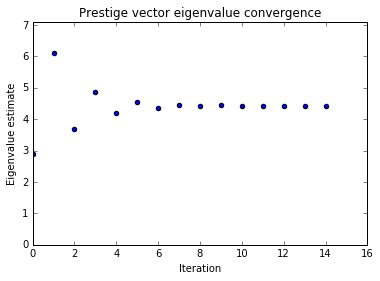

In [54]:
plt.figure(8)
plt.scatter(range(0,len(eigenvalue_list[1:])),eigenvalue_list[1:])
plt.xlim([0,(len(eigenvalue_list[1:]) + 1)])
plt.ylim([0,(max(eigenvalue_list[1:]) + 1)])
plt.xlabel('Iteration')
plt.ylabel('Eigenvalue estimate')
plt.title("Prestige vector eigenvalue convergence")
plt.savefig('Prestige scores')

Check to see if the probability of having degree k in the network follows a power law, which indicates that the overwhelming majority of nodes have very small degrees and the remaining more central nodes have very high degrees.

In [55]:
#Calculate the degree frequency distribution
max_degree = max(degree)

degree = np.array(degree)
print('Maximum degree: %i' % max_degree)

Maximum degree: 483


In [56]:
frequency = []
cumulative_frequency = []
for i in xrange(max_degree):
    frequency.append(len(degree[(degree == (i + 1))]))

#Calculate the degree cumulative frequency distribution
cumulative_frequency.append(frequency[0])
for i in range(1,max_degree):
    cumulative_frequency.append((cumulative_frequency[i - 1] + frequency[i]))

cumulative_probability = np.array(cumulative_frequency)/max(cumulative_frequency)

#Calculate the log of complementary probability, exclude 0 and 1 values
log_complementary_cumulative_probability = np.log(1 - cumulative_probability[((cumulative_probability != 1) & (cumulative_probability != 0))])
log_degree = np.log(np.array(range(1,max_degree)))

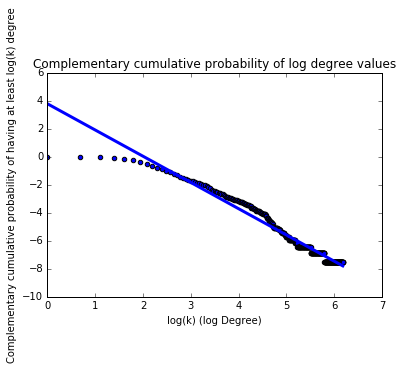

In [75]:
plt.figure(9)
plt.scatter(log_degree,log_complementary_cumulative_probability)
plt.xlabel("log(k) (log Degree)")
plt.ylabel("Complementary cumulative probability of having at least log(k) degree")
plt.title("Complementary cumulative probability of log degree values")
plt.xlim([0, np.round(max(log_degree) + 1)])
#Fit a linear model to data
frequency_model = linear_model.LinearRegression()
log_degree = np.reshape(log_degree,(len(log_degree),1))
frequency_model.fit(log_degree,log_complementary_cumulative_probability)
predictions = frequency_model.predict(log_degree)
coef = frequency_model.coef_
standard_error = np.sqrt(np.sum(np.power(log_complementary_cumulative_probability - predictions,2))/(len(log_degree) - 1))
t_value = coef/standard_error
p_value = 1 - t.sf(t_value, len(log_degree) - 1)
plt.plot(log_degree,predictions, color='blue', linewidth=3)
plt.savefig('Log degree vs complementary cumulative probability')

In [76]:
print('Line coefficient: %.3f: ' % coef,'t score: %.3f ' % t_value,'p-value: %.5f' % p_value)

('Line coefficient: -1.882: ', 't score: -5.120 ', 'p-value: 0.00000')


The p-value indicates that the coefficient of the linear model is statistically significantly different from zero, and that the complementary probability of having at least k degrees decreases as the log of k increases. The network exhibits a power-law relationship, where most of the institutions partner with a few other institutions and a smaller number of them have a large number of partnerships.

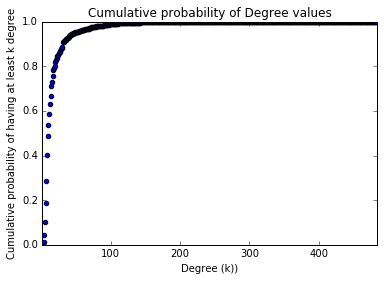

In [77]:
plt.figure(10)
plt.scatter(range(1,max(degree) + 1),cumulative_probability)
plt.xlabel("Degree (k))")
plt.ylabel("Cumulative probability of having at least k degree")
plt.title("Cumulative probability of Degree values")
plt.xlim([1, max(degree) + 1])
plt.ylim([0, 1])
plt.savefig('Degree vs cumulative probability')

The high average clustering coefficient indicates that if two institutions participate in projects in a third institution, those two institutions are also likely to participate in a project. Another way to look at the clustering property of a network is to fir a linear model to the log-log plot of degree k vs. average clustering coefficient of nodes with the degree k and see if the linear model is significant.

In [97]:
clustering_coefficient = np.array(clustering_coefficient)
average_clustering_coefficient = []
degree_clusters = []
for i in xrange(max_degree):
    if len(clustering_coefficient[(degree == i + 1)]) != 0:
        average_clustering_coefficient.append(np.average(clustering_coefficient[(degree == i + 1)]))
        degree_clusters.append((i + 1))

log_degree_clusters = np.log(degree_clusters)[2:]
log_average_clustering_coefficient = np.log(average_clustering_coefficient)[2:]

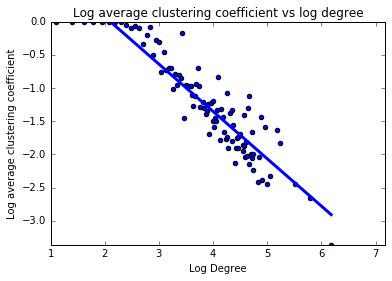

In [95]:
plt.figure(11)
plt.scatter(log_degree_clusters,log_average_clustering_coefficient)
plt.xlabel("Log Degree")
plt.ylabel("Log average clustering coefficient")
plt.title("Log average clustering coefficient vs log degree")
plt.xlim([1, max(log_degree_clusters) + 1])
plt.ylim([min(log_average_clustering_coefficient),0])     
plt.savefig('Log average clustering coefficient vs log degree')

#Fit a linear model to data
cluster_model = linear_model.LinearRegression()
log_degree_clusters = np.reshape(log_degree_clusters,(len(log_degree_clusters),1))
cluster_model.fit(log_degree_clusters,log_average_clustering_coefficient)
predictions = cluster_model.predict(log_degree_clusters)
coef = cluster_model.coef_
standard_error = np.sqrt(np.sum(np.power(log_average_clustering_coefficient - predictions,2))/(len(log_degree_clusters) - 1))
t_value = coef/standard_error
p_value = 1 - t.sf(t_value, len(degree_clusters) - 1)
plt.plot(log_degree_clusters,predictions, color='blue', linewidth=3)

In [96]:
print('Line coefficient: %.3f: ' % coef,'t score: %.3f ' % t_value,'p-value: %.5f' % p_value)

('Line coefficient: -0.713: ', 't score: -2.518 ', 'p-value: 0.00669')


The p-value indicates that the network exhibits a clustering effect, indicating that nodes with small number of degrees tend to participate in projects mostly with a specific group of institutions, and institutions with high degrees participate in projects of different clusters.

In [76]:
#Output the degree scores 
degree = pd.DataFrame.from_items([('Institution',institutions),('Degree',degree)])
degree = degree.sort_values(by = 'Degree', axis = 0, ascending = False)
pd.DataFrame(degree).to_csv('degree_scores.csv',index = False)   

#Output the indegree scores 
indegree = pd.DataFrame.from_items([('Institution',institutions),('Indegree',indegree)])
indegree = indegree.sort_values(by = 'Indegree', axis = 0, ascending = False)
pd.DataFrame(indegree).to_csv('indegree_scores.csv',index = False)

#Output the clustering coefficient scores 
clustering_coefficient = pd.DataFrame.from_items([('Institution',institutions),('Clustering_coefficient',clustering_coefficient)])
clustering_coefficient = clustering_coefficient.sort_values(by = 'Clustering_coefficient', axis = 0, ascending = False)
pd.DataFrame(clustering_coefficient).to_csv('clustering_coefficient_scores.csv',index = False)  

#Output the eccentricity scores
eccentricity = pd.DataFrame.from_items([('Institution',institutions),('Eccentricity',eccentricity)])
eccentricity = eccentricity.sort_values(by = 'Eccentricity', axis = 0, ascending = False)
pd.DataFrame(eccentricity).to_csv('eccentricity_scores.csv',index = False)

#Output the hub scores
hub_scores = pd.DataFrame.from_items([('Institution',institutions),('Hub_scores',h_new)])
hub_scores = hub_scores.sort_values(by = 'Hub_scores', axis = 0, ascending = False)
pd.DataFrame(hub_scores).to_csv('hub_scores.csv',index = False)

#Output the authority scores
authority_scores = pd.DataFrame.from_items([('Institution',institutions),('Authority_scores',a_new)])
authority_scores = authority_scores.sort_values(by = 'Authority_scores', axis = 0, ascending = False)
pd.DataFrame(authority_scores).to_csv('authority_scores.csv',index = False)

#Output the Prestige scores
prestige_scores = pd.DataFrame.from_items([('Institution',institutions),('Prestige_scores',prestige_new)])
prestige_scores = prestige_scores.sort_values(by = 'Prestige_scores', axis = 0, ascending = False)
pd.DataFrame(prestige_scores).to_csv('prestige_scores.csv',index = False)

In [77]:
#Print the institutions with the highest degree, indegree, 
#clustering coefficient, eccentricity, prestige, 
#authority and hub scores.
print('Degree scores')
print(degree.head())

print('Indegree scores')
print(indegree.head())

print('Clustering coefficient scores')
print(clustering_coefficient.head())

print('Eccentricity scores')
print(eccentricity.head())

print('Prestige scores')
print(prestige_scores.head())

print('Authority scores')
print(authority_scores.head())

print('Hub scores')
print(hub_scores.head())

Degree scores
                                            Institution  Degree
739   FRAUNHOFER-GESELLSCHAFT ZUR FOERDERUNG DER ANG...     483
1436  COMMISSARIAT A L ENERGIE ATOMIQUE ET AUX ENERG...     328
786                                       ATOS SPAIN SA     247
1010           TELEFONICA INVESTIGACION Y DESARROLLO SA     186
981                                           ORANGE SA     178
Indegree scores
                                            Institution  Indegree
739   FRAUNHOFER-GESELLSCHAFT ZUR FOERDERUNG DER ANG...      46.0
1436  COMMISSARIAT A L ENERGIE ATOMIQUE ET AUX ENERG...      23.0
1497       CENTRE NATIONAL DE LA RECHERCHE SCIENTIFIQUE      20.0
1082                                  IBM RESEARCH GMBH      17.0
1010           TELEFONICA INVESTIGACION Y DESARROLLO SA      16.0
Clustering coefficient scores
                                      Institution  Clustering_coefficient
0                    THE DCU RYAN ACADEMY LIMITED                     1.0
1164        